In [111]:
import kaolin
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import polyscope as ps
import interactive_polyscope
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh
from scipy.spatial import Delaunay, Voronoi


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"


Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
#currently sites are between -5 and 5 in all 3 dimensions
# check if sites exists
#num_centroids = 16*16*16
num_centroids = 8*8*8
site_fp = f'sites_{num_centroids}_{input_dims}.pt'

if os.path.exists(site_fp):
    sites = torch.load(site_fp)
else:
    sites = su.createCVTgrid(num_centroids=num_centroids, dimensionality=input_dims)
    #save the initial sites torch tensor
    torch.save(sites, site_fp)


def plot_voronoi_3d(sites, xlim=5, ylim=5, zlim=5):
    import numpy as np
    import pyvoro
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    # initialize random number generator
    rng = np.random.default_rng(11)
    # create a set of points in 3D
    points = sites.detach().cpu().numpy()

    # use pyvoro to compute the Voronoi tessellation
    # the second argument gives the the axis limits in x,y and z direction
    # in this case all between 0 and 1.
    # the third argument gives "dispersion = max distance between two points
    # that might be adjacent" (not sure how exactly this works)
    voronoi = pyvoro.compute_voronoi(points,[[-xlim,xlim],[-ylim,ylim],[-zlim,zlim]],1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # for each Voronoi cell, plot all the faces of the corresponding polygon
    for vnoicell in voronoi:
        faces = []
        # the vertices are the corner points of the Voronoi cell
        vertices = np.array(vnoicell['vertices'])
        # cycle through all faces of the polygon
        for face in vnoicell['faces']:
            faces.append(vertices[np.array(face['vertices'])])
            
        # join the faces into a 3D polygon
        polygon = Poly3DCollection(faces, alpha=0.5, 
                                facecolors=rng.uniform(0,1,3),
                                linewidths=0.5,edgecolors='black')
        ax.add_collection3d(polygon)
    
    ax.set_xlim([-xlim,xlim])
    ax.set_ylim([-ylim,ylim])
    ax.set_zlim([-zlim,zlim])
            
    plt.show()

#plot_voronoi_3d(sites)

In [113]:
ps.init()
#ps_cloud = ps.register_point_cloud("initial_cvt_grid",sites.detach().cpu().numpy())

In [114]:

# Load the mesh
mesh = ["bunny", "Resources/stanford-bunny.obj"]
bunny = trimesh.load(mesh[1])

# Step 1: Get current bounding box
min_bound = bunny.bounds[0]  # Min (x, y, z)
max_bound = bunny.bounds[1]  # Max (x, y, z)

# Step 2: Compute scale factor
current_size = max_bound - min_bound  # Size in each dimension
target_size = 8  # Because we want [-5, 5], the total size is 10

scale_factor = target_size / np.max(current_size)  # Scale based on the largest dimension

# Step 3: Compute new center after scaling
new_vertices = bunny.vertices * scale_factor  # Scale the vertices
new_min = np.min(new_vertices, axis=0)
new_max = np.max(new_vertices, axis=0)
new_center = (new_min + new_max) / 2  # New center after scaling

# Step 4: Compute translation to center the bunny at (0,0,0)
translation = -new_center  # Move to the origin

# Step 5: Apply transformation (scaling + translation)
bunny.vertices = new_vertices + translation

target_points = bunny.sample(16*16*16)
target_points = torch.tensor(target_points, device=device)

#ps_cloud = ps.register_point_cloud("Target_points",target_points.detach().cpu().numpy())


In [115]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=input_dims).to(device)
model_path = 'models_resources/pretrained_sphere_small.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_sphere(3000)
    torch.save(model.state_dict(),model_path)
    
def polyscope_sdf(model):
    # Render the SDF as an implicit surface (zero-level set)
    def model_sdf(pts):
        pts_tensor = torch.tensor(pts, dtype=torch.float64, device=device)
        sdf_values = model(pts_tensor)
        sdf_values_np = sdf_values.detach().cpu().numpy().flatten()  # Convert to NumPy
        
        return sdf_values_np

    ps.render_implicit_surface("SDF Surface", model_sdf, mode="sphere_march", enabled=True)



loaded model


In [ ]:
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_target_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
], betas=(0.5, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_target_points = lambda_weights[7]
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute, bisectors_to_compute = su.compute_zero_crossing_vertices_3d(sites, model)
        vertices = su.compute_vertices_3d_vectorized(sites, vertices_to_compute)    
        bisectors = su.compute_all_bisectors_3d_vectorized(sites, bisectors_to_compute)
        #combine vertices and bisectors to one tensor for chamfer
        points = torch.cat((vertices, bisectors), 0)


        # Compute losses       
        cvt_loss = lf.compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        #min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = lf.chamfer_distance(target_points, points)
        eikonal_loss = lf.eikonal(model, input_dimensions=input_dims)
        #domain_restriction_loss = lf.domain_restriction(target_points, model)
        
        sdf_values_target_points = model(target_points)[:,0]
        zero_target_points_loss_L2 = torch.mean(sdf_values_target_points**2)
        zero_target_points_loss_L1 = torch.mean(torch.abs(model(target_points)[:, 0]))
        lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        zero_target_points_loss = lambda_1 * zero_target_points_loss_L1 + lambda_2 * zero_target_points_loss_L2

               
        # Track raw losses (unweighted)
        #cvt_loss_values.append(cvt_loss.item())
        #min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        #domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_target_points_loss_values.append(zero_target_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            #lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            #lambda_domain_restriction * domain_restriction_loss +
            lambda_target_points * zero_target_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
        
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
            print("sites length: ",len(sites))
            
            new_sites = su.upsampling_inside(best_sites, model)
            #new_sites = su.adaptive_density_upsampling(best_sites, model)
            print(new_sites)
            sites = su.add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0
          
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            #save model and sites
            site_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_sites_{num_centroids}_chamfer{lamda_chamfer}.pth'
            model_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_model_{num_centroids}_chamfer{lamda_chamfer}.pth'
            torch.save(model.state_dict(), model_file_path)
            torch.save(sites, site_file_path)
            
        
        epoch += 1           
        
    return best_sites

Importing sites
Sites length:  512
min sites:  tensor(-5.3585, grad_fn=<MinBackward1>)
max sites:  tensor(5.4342, grad_fn=<MaxBackward1>)


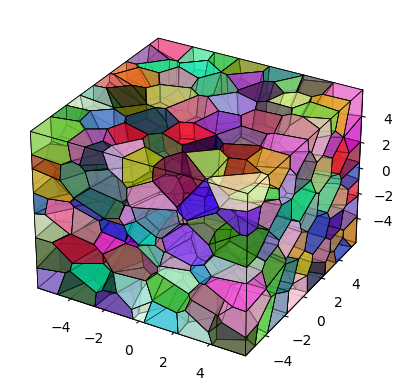

In [118]:

lambda_weights = [0.2,0,0.1,0,1.0001101101000101,0.1,0,2]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_target_points = lambda_weights[7]

max_iter = 100

site_file_path = f'{destination}{mesh[0]}{max_iter}3d_sites_{num_centroids}_chamfer{lamda_chamfer}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)    
else:
    import cProfile, pstats
    import time
    profiler = cProfile.Profile()
    profiler.enable()
    sites = autograd(sites, model, max_iter=max_iter, upsampling=0, lambda_weights=lambda_weights)
    
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats('cumtime')
    stats.print_stats()
    stats.dump_stats(f'{destination}{mesh[0]}{max_iter}_3d_profile_{num_centroids}_chamfer{lamda_chamfer}.prof')
    
    
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    

print("Sites length: ", len(sites))
print("min sites: ", torch.min(sites))
print("max sites: ", torch.max(sites))
ps_cloud = ps.register_point_cloud("best_optimized_cvt_grid",sites.detach().cpu().numpy())
    
lim=torch.abs(torch.max(sites)).detach().cpu().numpy()*1.1
plot_voronoi_3d(sites,lim,lim,lim)

In [119]:
epoch = 100

model_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_model_{num_centroids}_chamfer{lamda_chamfer}.pth'
site_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_sites_{num_centroids}_chamfer{lamda_chamfer}.pth'
sites = torch.load(site_file_path)
sites_np = sites.detach().cpu().numpy()
model.load_state_dict(torch.load(model_file_path))
#
#polyscope_sdf(model)
#
print("model", model_file_path)
print("sites", site_file_path)
#ps_cloud = ps.register_point_cloud(f"{epoch} epoch_cvt_grid",sites_np)



model ./images/autograd/3D/bunny100_100_3d_model_512_chamfer1.00011011010001.pth
sites ./images/autograd/3D/bunny100_100_3d_sites_512_chamfer1.00011011010001.pth


In [120]:
def get_zero_crossing_mesh_3d(sites, model):
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)  # Compute 3D Voronoi diagram

    sdf_values = model(sites)[:, 0].detach().cpu().numpy()  # Compute SDF values

    valid_faces = []  # List of polygonal faces
    used_vertices = set()  # Set of indices for valid vertices

    for (point1, point2), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        if -1 in ridge_vertices:
            continue  # Skip infinite ridges

        # Check if SDF changes sign across this ridge
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            valid_faces.append(ridge_vertices)
            used_vertices.update(ridge_vertices)

    # **Filter Voronoi vertices**
    used_vertices = sorted(used_vertices)  # Keep unique, sorted indices
    vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(used_vertices)}
    filtered_vertices = vor.vertices[used_vertices]

    # **Re-index faces to match the new filtered vertex list**
    filtered_faces = [[vertex_map[v] for v in face] for face in valid_faces]

    return filtered_vertices, filtered_faces



final_mesh = get_zero_crossing_mesh_3d(sites, model)

ps.register_surface_mesh("Zero-Crossing faces", final_mesh[0], final_mesh[1])
ps.register_point_cloud("Mesh vertices", final_mesh[0])

ps.show()



In [121]:
def export_visualisation_3d():
    import imageio
    img_buffer_mesh = []
    img_buffer_model = []
    for i in range(int(max_iter/10)+1):
        epoch = i*10
        site_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_sites_{num_centroids}_chamfer{lamda_chamfer}.pth'
        model_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_model_{num_centroids}_chamfer{lamda_chamfer}.pth'
        
        print("mesh of epoch: ", epoch)
        
        model.load_state_dict(torch.load(model_file_path))
    
        current_mesh = get_zero_crossing_mesh_3d(torch.load(site_file_path), model)
        ps.remove_all_structures()
        ps.register_surface_mesh("Zero-Crossing faces", current_mesh[0], current_mesh[1])
        ps.register_point_cloud("Mesh vertices", current_mesh[0])
        img_buffer_mesh.append(ps.screenshot_to_buffer(transparent_bg=False))
        
        ps.remove_all_structures()
        polyscope_sdf(model)
        img_buffer_model.append(ps.screenshot_to_buffer(transparent_bg=False))


    imageio.mimsave(f'{destination}{max_iter}_3d_optimization_mesh.gif',img_buffer_mesh, fps=1, duration=1, loop=0)
    imageio.mimsave(f'{destination}{max_iter}_3d_optimization_sdf.gif', img_buffer_model, fps=1, duration=1, loop=0)

#export_visualisation_3d()